In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [2]:
ds = tfds.load('spoken_digit', split='train', as_supervised=True)

[<tf.Tensor: shape=(2689,), dtype=int64, numpy=array([ -768, -1280, -1024, ...,  -512,  -256,  -256], dtype=int64)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>]
tf.Tensor([ -768 -1280 -1024 ...  -512  -256  -256], shape=(2689,), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


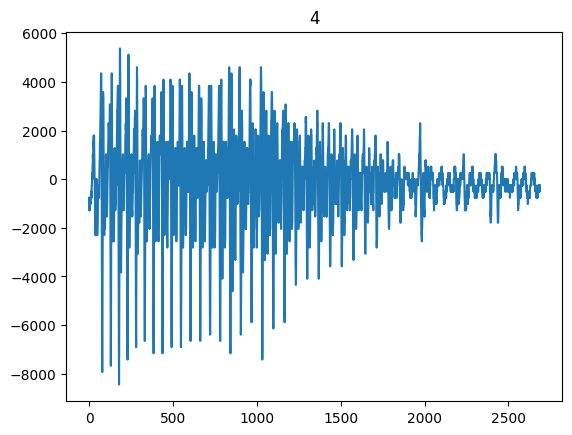

In [86]:
ex = ds.take(1)
for example in ex:
    print(list(example))
    print(example[0])
    print(example[1])
    plt.plot(example[0])
    plt.title(tf.keras.backend.get_value(example[1]))

In [4]:
# NEED TO PAD THE DATA

ds = ds.shuffle(2500, seed = 42)
ds_train = ds.skip(500)
ds_test = ds.take(500)

max_length = max(len(sample[0]) for sample in ds)
print(max_length)

# OK there is one audio file that is way longer than the rest so we need to handle that for padding
# look into np.pad

ds_train_audio = list(ds_train.map(lambda x, y: x).as_numpy_iterator())
ds_train_label = list(ds_train.map(lambda x, y: y).as_numpy_iterator())

ds_test_audio = list(ds_test.map(lambda x, y: x).as_numpy_iterator())
ds_test_label = list(ds_test.map(lambda x, y: y).as_numpy_iterator())

18262


In [88]:
# For now remove the audio samples that are too long
ds_train_label = [ds_train_label[i] for i, x in enumerate(ds_train_audio) if len(x) < 5000]
ds_train_audio = [x for x in ds_train_audio if len(x) < 5000]

ds_test_label = [ds_test_label[i] for i, x in enumerate(ds_test_audio) if len(x) < 5000]
ds_test_audio = [x for x in ds_test_audio if len(x) < 5000]

#print(sum(len(sample) > 5000 for sample in ds_train_audio))
print("Size of sample:", len(ds_train_label))
print("Size of test:", len(ds_test_label))

Size of sample: 1904
Size of test: 480


In [89]:
# Now we pad each samples with an even number of zeros on each side

def normalize(sample):
    return (sample - np.mean(sample)) / np.std(sample)

def pad_audio(sample):
    sample_length = len(sample)
    pad_width = 5000 - sample_length

    if pad_width <= 0:
        return sample
    
    if pad_width % 2 == 0:
        pad_width = int(pad_width / 2)
        return np.pad(sample, pad_width, 'constant', constant_values=0)
    else:
        pad_width = int(pad_width // 2)
        return np.pad(sample, (pad_width, pad_width + 1), 'constant', constant_values=0)

for sample in range(len(ds_train_audio)):
    ds_train_audio[sample] = normalize(ds_train_audio[sample])
    ds_train_audio[sample] = pad_audio(ds_train_audio[sample])

for sample in range(len(ds_test_audio)):
    ds_test_audio[sample] = normalize(ds_test_audio[sample])
    ds_test_audio[sample] = pad_audio(ds_test_audio[sample])


In [90]:
ds_train_audio = np.array(ds_train_audio)
ds_test_audio = np.array(ds_test_audio)
ds_train_label = to_categorical(np.array(ds_train_label))
ds_test_label = to_categorical(np.array(ds_test_label))


In [91]:
# Audio needs to be of shape (5000, num_of_samples, 1)
ds_train_audio = ds_train_audio.reshape(ds_train_audio.shape[0], ds_train_audio.shape[1], 1)
ds_test_audio = ds_test_audio.reshape(ds_test_audio.shape[0], ds_test_audio.shape[1], 1)

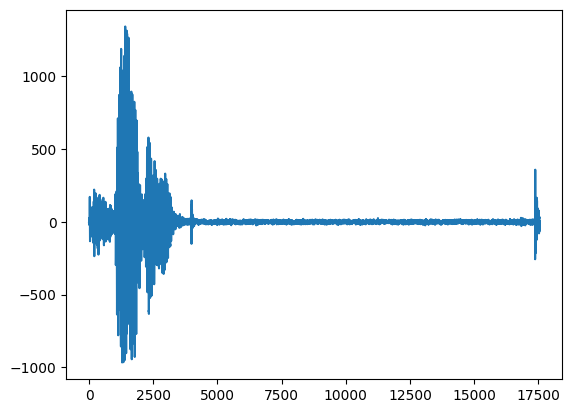

4

In [32]:
# max_index = np.argmax(list(len(sample) for sample in ds_train_audio))
# plt.plot(ds_train_audio[max_index])
# plt.show()
# ds_train_audio.pop(max_index)
# ds_train_label.pop(max_index)

# max_index = np.argmax(list(len(sample) for sample in ds_train_audio))
# plt.plot(ds_train_audio[max_index])
# plt.show()
# ds_train_audio.pop(max_index)
# ds_train_label.pop(max_index)


In [101]:
# Filters = number of matrices to slide across

model = models.Sequential()
model.add(layers.Conv1D(64, 7, activation = "relu", input_shape = (5000, 1)))
model.add(layers.AveragePooling1D(2))
model.add(layers.Conv1D(128, 7, activation = "relu"))
model.add(layers.AveragePooling1D(2))
model.add(layers.Conv1D(256, 5, activation = "relu"))
model.add(layers.AveragePooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(2000, activation = "relu"))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = "softmax"))

In [102]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train_audio, ds_train_label, epochs=10, batch_size=32,
                    validation_data=(ds_test_audio, ds_test_label))

Epoch 1/10
34/60 [================>.............] - ETA: 36s - loss: 2.8168 - accuracy: 0.0947

KeyboardInterrupt: 

In [14]:
# for x in ds_train_audio:
#    print(len(x))